### Your name:

<pre> Isaac Aktam</pre>

### Collaborators:

<pre> Ashish Gupta, Konrad Korzeniewski</pre>

## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [6]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [7]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [8]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [9]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [12]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [13]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [25]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.88375656825


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [26]:
from sklearn.svm import SVR

# C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] ## YOUR VALUES FOR C ##
# gamma_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] ## YOUR VALUES FOR gamma ## 

C_vals = [100000, 1000000] ## YOUR VALUES FOR C ##
gamma_vals = [0.01, 0.1, 1] ## YOUR VALUES FOR gamma ## 

#C_vals = [100000, 1000000, 10000000, 100000000, 1000000000] ## YOUR VALUES FOR C ##
#gamma_vals = [0.01, 0.1, 1] ## YOUR VALUES FOR gamma ## 

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [100000, 1000000], 'gamma': [0.01, 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

# {'C': 10000, 'gamma': 0.1}
# 62439.06054204476

# {'C': 1000000, 'gamma': 0.1}
# 55421.59987804083

{'C': 1000000, 'gamma': 0.1}
55421.59987804083


### Performance on Test Set

In [28]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse) # 54175.05097778363

54175.05097778363


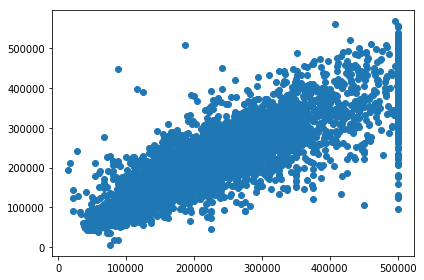

In [29]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(700,5))

plt.scatter(x=np.array(y_te), y=y_te_estimation)
#plt.xlim([-200000,800000])
#plt.ylim([-200000,800000])
#plt.xticks(x_axis, rotation='vertical') # New
plt.tight_layout() # New

plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [17]:
from sklearn.metrics import accuracy_score

In [18]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [32]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [49]:
from sklearn.svm import LinearSVC

In [50]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [51]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.8385243632336655

In [52]:
# Calculate the RMSE

final_mse_linearSVC = mean_squared_error(y_tr_b, y_pred)
final_rmse_linearSVC = np.sqrt(final_mse_linearSVC)
print(final_rmse_linearSVC)

0.401840312520203


### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [33]:
from sklearn.svm import SVC

In [34]:
svc_default = SVC(random_state = 42)## YOUR CODE HERE ##

svc_default.fit(X_tr, y_tr_b)## YOUR CODE HERE ##

y_pred_svc_default = svc_default.predict(X_tr)## YOUR CODE HERE ##
accuracy_score(y_tr_b, y_pred_svc_default) ## YOUR CODE HERE ##

0.866140642303433

In [35]:
from sklearn.metrics import mean_squared_error

final_mse_svc_default = mean_squared_error(y_tr_b, y_pred_svc_default)
final_rmse_svc_default = np.sqrt(final_mse_svc_default)
print(final_rmse_svc_default)

0.36586795117441895


### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [37]:
#param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(100, 1000)}
#param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(100000, 1000000)}
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(10000, 100000)}
rnd_search_cv = RandomizedSearchCV(svc_default, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_tr, y_tr_b)
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=28418.639408307423, gamma=0.007320816089928332 ................
[CV] . C=28418.639408307423, gamma=0.007320816089928332, total=  40.9s
[CV] C=28418.639408307423, gamma=0.007320816089928332 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.0s remaining:    0.0s


[CV] . C=28418.639408307423, gamma=0.007320816089928332, total=  45.8s
[CV] C=28418.639408307423, gamma=0.007320816089928332 ................
[CV] . C=28418.639408307423, gamma=0.007320816089928332, total=  47.4s
[CV] C=42184.20647414537, gamma=0.013894437412325513 .................
[CV] .. C=42184.20647414537, gamma=0.013894437412325513, total= 1.5min
[CV] C=42184.20647414537, gamma=0.013894437412325513 .................
[CV] .. C=42184.20647414537, gamma=0.013894437412325513, total= 1.4min
[CV] C=42184.20647414537, gamma=0.013894437412325513 .................
[CV] .. C=42184.20647414537, gamma=0.013894437412325513, total= 1.5min
[CV] C=98312.81397744245, gamma=0.015617273693055161 .................
[CV] .. C=98312.81397744245, gamma=0.015617273693055161, total= 3.4min
[CV] C=98312.81397744245, gamma=0.015617273693055161 .................
[CV] .. C=98312.81397744245, gamma=0.015617273693055161, total= 4.0min
[CV] C=98312.81397744245, gamma=0.015617273693055161 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 42.1min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe27208d240>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe27208d7b8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [38]:
rnd_search_cv.best_estimator_

SVC(C=28418.639408307423, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.007320816089928332,
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [39]:
rnd_search_cv.best_score_

0.8771456256921373

In [50]:
# Let's calculate the RMSE

svc_randomized = rnd_search_cv.best_estimator_ ## YOUR CODE HERE ##

y_pred_svc_randomized = svc_randomized.predict(X_tr)## YOUR CODE HERE ## FIX THIS!
accuracy_score(y_tr_b, y_pred_svc_randomized) ## YOUR CODE HERE ##

final_mse_svc_randomized = mean_squared_error(y_tr_b, y_pred_svc_randomized)
final_rmse_svc_randomized = np.sqrt(final_mse_svc_randomized)
print("Rmse is:",final_rmse_svc_randomized)
print("Best parameters are:", rnd_search_cv.best_params_) ## YOUR CODE HERE ##

Rmse is: 0.3267977791889581
Best parameters are: {'C': 28418.639408307423, 'gamma': 0.007320816089928332}


In [43]:
# Work with the test set

final_model_rand_search = rnd_search_cv.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation_rand_search = final_model_rand_search.predict(X_te)

final_mse = mean_squared_error(y_te_b, y_te_estimation_rand_search)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.3496491412313554


As we can see, the rmse on the test set is 0.3496 compared to the rmse on the train set 0.3267. Given that the rmse on the test set is higher by around 0.023 units, this suggests that the SVC model (derived from the randomized search) fits the data well.

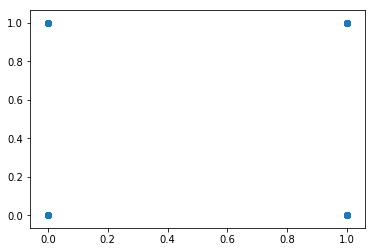

In [48]:
# Draw y_te_b vs y_te_estimation_rand_search
import matplotlib.pyplot as plt

plt.scatter(x=y_te_b, y=y_te_estimation_rand_search)
plt.show()

In [52]:
# Let's draw the learning curve

from sklearn.metrics import mean_squared_error

svc_randomized = rnd_search_cv.best_estimator_

train_errors, val_errors = [], []
for m in range(1000, len(X_tr), 1000):
    svc_randomized.fit(X_tr[:m], y_tr_b[:m]) # DO NOT DELETE
    y_train_predict = svc_randomized.predict(X_tr[:m])
    y_val_predict = svc_randomized.predict(X_te[:m])
    train_errors.append(mean_squared_error(y_train_predict, y_tr_b[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_te_b[:m]))
    print(m)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


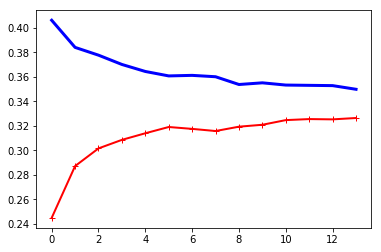

In [53]:
#plt.figure(figsize=(20,10))
import matplotlib.pyplot as plt
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()

As we can see from the above "Learning Curves" graph, validation error seems to be minimally greater than the training error suggesting that the model fits the data well. What a nice graph indeed.